# Análisis exploratorio y limpieza de Properati

## Precio por metro cuadrado de las propiedades

### Exploración de datos faltantes

Importamos el dataset.

In [842]:
import pandas as pd
df = pd.read_csv("properati.csv")

Inspeccionamos las columnas del dataset

In [843]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

Vemos que el dataset contiene las columnas

* ```price``` y ```currency``` que describren el precio (junto a su moneda) con la que fue publicada
* ```price_aprox_local_currency``` y ```price_aprox_usd``` contienen los estimados, segun alguna tasa de cambio, a pesos y dólares respectivamente.
* ```price_usd_per_m2```, ```price_per_m2``` para el precio por metros cuadrados en dólares y pesos respectivamente
* ```surface_covered_in_m2```, ```surface_total_in_m2``` con el tamaño de la propiedad en metros cuadrados. Consideramos que estas columnas podrían ser útiles para entender e imputar los precios por metros cuadrados.

**¿Cuantos nulos hay en cada una de estas columnas y cuanto representa sobre el total de registros?**

Primero, vamos a extraer las columnas que necesitamos para responder esta pregunta y guardarlo en un DataFrame, el cual podremos seguir utilizando más adelante.

In [844]:
price_related_columns = [
    'price',
    'currency',
    'price_aprox_local_currency',
    'price_aprox_usd',
    'price_usd_per_m2',
    'price_per_m2',
    'surface_covered_in_m2',
    'surface_total_in_m2'
]
price_related_df = df.loc[:, price_related_columns]

In [845]:
from IPython.display import Markdown, display

nulls_by_column = price_related_df.isnull().sum()
dataset_size = df.shape[0]

for column in nulls_by_column.index:
    column_nulls = nulls_by_column[column]
    null_percentage = 100 * column_nulls / dataset_size
    display(Markdown(f"* ```{column}``` tiene {column_nulls} nulos, lo cual representa el {null_percentage:.2f}%"))

* ```price``` tiene 20410 nulos, lo cual representa el 16.84%

* ```currency``` tiene 20411 nulos, lo cual representa el 16.84%

* ```price_aprox_local_currency``` tiene 20410 nulos, lo cual representa el 16.84%

* ```price_aprox_usd``` tiene 20410 nulos, lo cual representa el 16.84%

* ```price_usd_per_m2``` tiene 52603 nulos, lo cual representa el 43.39%

* ```price_per_m2``` tiene 33562 nulos, lo cual representa el 27.69%

* ```surface_covered_in_m2``` tiene 19907 nulos, lo cual representa el 16.42%

* ```surface_total_in_m2``` tiene 39328 nulos, lo cual representa el 32.44%

Vemos que, en cada uno de estos casos tenemos una cantidad importante de elementos nulos. En especial, notamos que hay más registros con *precio por metro cuadrado* nulo que registros con el *precio* nulo, por lo que creemos que podríamos imputar una parte del precio por metro cuadrado sin introducir sesgos con la propia imputación.

Dado que vemos la posibilidad imputar el precio por metro cuadrado utilizando las variables *precio* y *superficie*, nos planteamos que tanto nos mejora el dataset que tenemos, por lo tanto nos preguntamos:

**¿Cuantos registros no tienen precio por metro cuadrado pero sí precio y superficie? \
¿Cómo es esta cantidad respecto el total?**

In [846]:
# Predicates that describe the question
has_price = ~df.price.isnull()
has_surface_covered_in_m2 = ~df.surface_covered_in_m2.isnull()
has_surface_total_in_m2 = ~df.surface_total_in_m2.isnull()
has_null_price_usd_per_m2 = df.price_usd_per_m2.isnull()

imputable_price_m2_by_price_surface_mask = has_price & (has_surface_covered_in_m2 | has_surface_total_in_m2) & has_null_price_usd_per_m2
imputable_price_m2_by_price_surface_quantity = df.loc[imputable_price_m2_by_price_surface_mask].shape[0]

imputable_price_m2_by_price_surface_total_relation = 100 * imputable_price_m2_by_price_surface_quantity / dataset_size

nulls_in_price_m2_usd = nulls_by_column['price_usd_per_m2']
imputable_price_m2_by_price_surface_null_relation = 100 * imputable_price_m2_by_price_surface_quantity / nulls_in_price_m2_usd

left_to_impute_price_m2 = nulls_in_price_m2_usd - imputable_price_m2_by_price_surface_quantity
left_to_impute_price_m2_percentage = 100 * (nulls_in_price_m2_usd - imputable_price_m2_by_price_surface_quantity) / dataset_size

display(Markdown(f"""
Utilizando imputación por precio y superficie conseguiremos imputar {imputable_price_m2_by_price_surface_quantity}
registros, lo cual representa un {imputable_price_m2_by_price_surface_total_relation:.2f}% del total de registros
y además un {imputable_price_m2_by_price_surface_null_relation:.2f}% de los registros con precios por metros
cuadrados nulos. Habiéndolo hecho, sólo quedarán {left_to_impute_price_m2}, es decir, 
{left_to_impute_price_m2_percentage:.2f}% del dataset
"""))


Utilizando imputación por precio y superficie conseguiremos imputar 24557
registros, lo cual representa un 20.26% del total de registros
y además un 46.68% de los registros con precios por metros
cuadrados nulos. Habiéndolo hecho, sólo quedarán 28046, es decir, 
23.14% del dataset


In [847]:
price_without_surface = df.loc[~has_price & (has_surface_covered_in_m2 | has_surface_total_in_m2)].shape[0]
surface_without_price = df.loc[has_price & ~(has_surface_covered_in_m2 | has_surface_total_in_m2)].shape[0]

problematic_imputation_price_m2 = (100 * (price_without_surface + surface_without_price) / dataset_size)

display(Markdown(f"""
Sin embargo, queremos ver que podemos hacer con ese 23% de datos. Veamos como están estos datos. \n
Hay {price_without_surface} registros con precio pero con superficie nula y
{surface_without_price} registros con superficie pero con el precio nulo. \n
Esto vendría a representar {problematic_imputation_price_m2:.2f}% del dataset.
"""))


Sin embargo, queremos ver que podemos hacer con ese 23% de datos. Veamos como están estos datos. 

Hay 15677 registros con precio pero con superficie nula y
7636 registros con superficie pero con el precio nulo. 

Esto vendría a representar 19.23% del dataset.


*Supongamos* que podamos obtener un estimado de superficie dado una cierta cantidad de ambientes de la propiedad.

**¿Cuantos podríamos imputar, al menos por tipo de propiedad?**

In [848]:
has_rooms = df.rooms.isnull()
has_rooms_but_not_specified_surface_mask = has_rooms & ~has_price & (has_surface_covered_in_m2 | has_surface_total_in_m2)
has_rooms_but_not_specified_surface = df.loc[has_rooms_but_not_specified_surface_mask]
imputable_surface_by_rooms = has_rooms_but_not_specified_surface.shape[0]
imputable_surface_by_rooms_percentage = 100 * (imputable_surface_by_rooms / dataset_size)
left_to_impute_percentage = problematic_imputation_price_m2 - imputable_surface_by_rooms_percentage

display(Markdown(f"""
Podemos imputar {imputable_surface_by_rooms} registros de superficie utilizando los ambientes de la propiedad.
Representando un {imputable_surface_by_rooms_percentage:.2f}% del total.
En este sentido, quedarían {left_to_impute_percentage:.2f}% de precios  por metro cuadrado que quedan por imputar.
"""))


Podemos imputar 10213 registros de superficie utilizando los ambientes de la propiedad.
Representando un 8.43% del total.
En este sentido, quedarían 10.81% de precios  por metro cuadrado que quedan por imputar.


Quiere decir que si planteamos una estrategia de imputación de la superficie, solo nos quedarían por imputar un 10% más.

Por otro lado, aunque hemos hecho ciertos cálculos sobre la efectividad que tienen distintos approach de imputación, reconocemos que el cálculo puede no ser del todo exacto, esto es porque relaciones entre precio, superficie cubierta y total pueden depender de la zona o el  tipo de propiedad.

**Aclaración acerca la comparación de precios de propiedades**

Para poder comparar dos datos de la forma más efectiva, estos deben estar en una unidad inmutable. No obstante, para el caso de los precios esto no es del todo posible, dado que se expresa en una moneda en concreto, cuyo valor fluctúa en el tiempo.

**¿Cual es la tasa de cambio a dólares para los inmuebles en pesos?**

In [849]:
currency_conversions = (df.price[df.currency == 'ARS'] / df.price_aprox_usd[df.currency == 'ARS'])

In [850]:
currency_conversions.describe()

count    13219.000000
mean        17.814183
std          0.102316
min         17.143000
25%         17.830500
50%         17.830501
75%         17.830502
max         17.830531
dtype: float64

**¿Cual es la tasa de cambio a dólares para los inmuebles en dólares?**

In [851]:
(df.price_aprox_local_currency[df.currency == 'USD'] / df.price[df.currency == 'USD']).describe()

count    8.758700e+04
mean     1.764450e+01
std      1.236618e-08
min      1.764450e+01
25%      1.764450e+01
50%      1.764450e+01
75%      1.764450e+01
max      1.764450e+01
dtype: float64

**Aclaración acerca de las tasas de cambio**

Notamos en la sección anterior que se describen precios en dólares en torno a los 17 pesos por dólar (variando en decimales) y con una cierta desviación típica que, aunque parezca pequeña (en torno a 0.1), para el valor de las propiedades puede significar una gran diferencia.

**Decisión de diseño y consideraciones**

Estamos considerando el USD como una moneda relativamente inmutable, esto no es del todo cierto, dado que sufre en torno al 2% de inflación anual. En consecuencia, estimar el valor de una propiedad en dólares utilizando la muestra que tenemos puede llevar a un cierto margen de error que aunque podamos estimarlo con diversos indicadores econmómicos.

### Estrategia de imputación

Con la exploración que hicimos anteriormente en torno al valor de los precios, creemos ya conveniente definir la estrategia de imputación, dividido en pasos.

1. Establecer una regla de conversión de pesos a dólares
2. Imputación de la columna ```surface_total_in_m2``` utilizando ```surface_covered_in_m2```
3. Imputar las columnas ```surface_total_in_m2``` y ```surface_covered_in_m2``` utilizando otras variables disponibles, como la cantidad de ambientes y el tipo de propiedad.
4. Imputar ```surface_covered_in_m2``` utilizando ```surface_total_in_m2```
5. Imputación de la columna ```price_usd_per_m2``` utilizando la columna ```price``` y ```surface_total_in_m2```

En cada imputación, agregaremos la columna con los datos calculados y además, una nueva columna que identificará si se ha imputado o no, da tal forma que pueda ser analizado a posteriori.

#### 1. Establecer una regla de conversión de pesos a dólares

**¿Qué tasa de cambio tomamos? ¿Cómo es la distribución de tasas de cambio?**

In [852]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

currency_conversions = df.price / df.price_aprox_usd
data = df.copy()
data['conversion_to_dolar'] = currency_conversions

conversion_description = data.loc[:, ['currency', 'conversion_to_dolar']].groupby('currency').describe()
conversion_description

conversion_to_dolar                                            \
                       count       mean           std     min      25%   
currency                                                                 
ARS                  13219.0  17.814183  1.023164e-01  17.143  17.8305   
PEN                      2.0   3.244000  3.916455e-08   3.244   3.2440   
USD                  87587.0   1.000000  0.000000e+00   1.000   1.0000   
UYU                      1.0  28.285000           NaN  28.285  28.2850   

                                           
                50%        75%        max  
currency                                   
ARS       17.830501  17.830502  17.830531  
PEN        3.244000   3.244000   3.244000  
USD        1.000000   1.000000   1.000000  
UYU       28.285000  28.285000  28.285000

In [853]:
ars_conversion = data.loc[(data.currency == 'ARS'), 'conversion_to_dolar']

print(f"""
El skew value es {ars_conversion.skew()}
""")


El skew value es -6.304800967952982



Como el skew es menor que -1, podemos afirmar que hay outliers hacia la izquierda. Esto también se puede ver de manera gráfica:

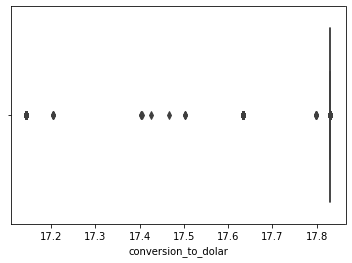

In [854]:
sns.boxplot(ars_conversion)

**¿Cómo sería la distribución quitando los outliers?**

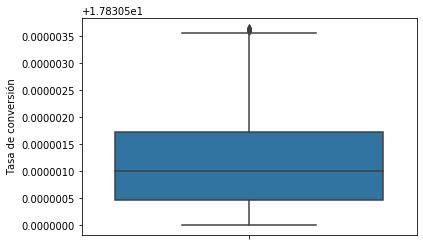

In [855]:
q1 = ars_conversion.quantile(0.25)
q2 = ars_conversion.quantile(0.5)
q3 = ars_conversion.quantile(0.75)

iqr = q3 - q1

up_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5* iqr

no_outliers_mask = (ars_conversion > low_threshold) & (ars_conversion < up_threshold)

ax = sns.boxplot(ars_conversion[no_outliers_mask], orient = 'v').set(
    xlabel='', 
    ylabel='Tasa de conversión'
)

In [856]:
print(f"El skew es {ars_conversion[no_outliers_mask].skew()} cuando quitamos los outliers")

El skew es 0.0 cuando quitamos los outliers


In [857]:
ars_conversion[no_outliers_mask].describe()

count    1.243400e+04
mean     1.783050e+01
std      8.698432e-07
min      1.783050e+01
25%      1.783050e+01
50%      1.783050e+01
75%      1.783050e+01
max      1.783050e+01
Name: conversion_to_dolar, dtype: float64

In [858]:
n_without_outliers = ars_conversion[no_outliers_mask].shape[0]
n_including_outliers = ars_conversion.shape[0]

taken_percentage = 100 * n_without_outliers / n_including_outliers
print(f"""
Sin outliers hemos tomado un {taken_percentage:.2f}% de los datos que teníamos.
Considerando solamente {n_including_outliers - n_without_outliers} registros como outliers
""")


Sin outliers hemos tomado un 94.06% de los datos que teníamos.
Considerando solamente 785 registros como outliers



Podemos ver que, quitando los outliers utilizando el rango intercuartil obtuvimos un rango de tasas de cambio más acotado y con una desviación típica en el orden de $10^{-7}$.

In [859]:
def get_outlier_bounds(series):
    # Compute quartiles
    q1 = series.quantile(0.25)
    q2 = series.quantile(0.5)
    q3 = series.quantile(0.75)

    # Compute interquartile range
    iqr = q3 - q1

    # Compute outlier thresholds
    up_threshold = q3 + 1.5 * iqr
    low_threshold = q1 - 1.5* iqr
    
    return low_threshold, up_threshold

In [860]:
def get_ars_2_usd_trimmed_mean(df):
    # Compute conversion for ARS
    currency_conversions_all = df.price / df.price_aprox_usd
    ars_conversion = currency_conversions_all[df.currency == 'ARS']
    
    # Get bounds
    low_threshold, up_threshold = get_outlier_bounds(ars_conversion)

    # Filter outliers
    no_outliers_mask = (ars_conversion > low_threshold) & (ars_conversion < up_threshold)
    ars_conversion_without_outliers = ars_conversion[no_outliers_mask]
    
    ars_conversion_trimmed_mean = ars_conversion_without_outliers.mean()
    return ars_conversion_trimmed_mean

Para tener una idea más precisa del error que podemos tener en la tasa de cambio, construimos un intervalo de confianza calculando la desviación típica entre el valor que produce la tasa de cambio que calculamos anteriormente sobre los precios en pesos y, fijando $\alpha = 0.05$.

In [861]:
from scipy import stats
import numpy as np

alpha = 0.05
conversion = get_ars_2_usd_trimmed_mean(df)

data_filtered = data[(data.currency == 'ARS') & ~data.price.isnull() & ~data.price_aprox_usd.isnull()]
N = data_filtered.shape[0]
x = data_filtered.price
y = data_filtered.price_aprox_usd
yhat = x / conversion

sum_errs = np.sum((y - yhat)**2)
stdev = np.sqrt(sum_errs / (N-1))

z = stats.t.ppf(alpha / 2, N - 1)
interval_95 = np.abs(z * stdev)

display(Markdown(f"""
El precio en dólares real de una propiedad con precio en pesos,
que no tiene especificado el precio en dólares, estará {interval_95:.2f} USD por arriba o por abajo
de lo calculado con la tasa de cambio de {conversion:.2f} pesos por dolar.
"""))


El precio en dólares real de una propiedad con precio en pesos,
que no tiene especificado el precio en dólares, estará 4983.36 USD por arriba o por abajo
de lo calculado con la tasa de cambio de 17.83 pesos por dolar.


Esta medida de error nos parece asequible para el orden de magnitud de los precios en dólares de un inmueble y, por esta razón, decidimos continuar con la media truncada como estrategia de conversión para los datos faltantes. El cálculo de la media truncada lo hemos encapsulado en una función para usarla más adelante.

#### 2. Imputación de la columna ```surface_total_in_m2``` utilizando ```surface_covered_in_m2```

**¿Son confiables estos valores?**

In [862]:
greater_covered_than_total_mask = (df.surface_covered_in_m2  > df.surface_total_in_m2)
greater_covered_than_total = df.loc[greater_covered_than_total_mask]
greater_covered_than_total_count = greater_covered_than_total.shape[0]

print(f"Hay {greater_covered_than_total_count} propiedades con mayor superficie cubierta que la total")

Hay 1106 propiedades con mayor superficie cubierta que la total


In [863]:
greater_covered_than_total.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'property_type']]\
    .groupby('property_type') \
    .describe()

surface_total_in_m2                                              \
                            count        mean         std   min    25%    50%   
property_type                                                                   
PH                           42.0   73.142857   34.043424  10.0   51.0   69.0   
apartment                   351.0   62.945869   65.376841  10.0   38.0   45.0   
house                       666.0  172.001502  155.085031  10.0   74.0  136.5   
store                        47.0  457.340426  845.014517  10.0  124.0  246.0   

                              surface_covered_in_m2                            \
                  75%     max                 count         mean          std   
property_type                                                                   
PH              95.00   154.0                  42.0   407.357143  1325.149855   
apartment       68.00   776.0                 351.0   314.438746  2685.712878   
house          224.75  1845.0                 666.0   462.887387  2122.211663   
store          398.00  4290.0                  47.0  1649.446809  5259.974669   

                                                   
                min    25%    50%    75%      max  
property_type                                      
PH             60.0   80.5  114.0  147.5   6610.0  
apartment      26.0   50.0   64.0   95.0  49000.0  
house          24.0  130.0  211.5  310.0  38240.0  
store          74.0  231.5  381.0  630.0  35000.0

In [864]:
multiplicative_relation = greater_covered_than_total.surface_covered_in_m2 / greater_covered_than_total.surface_total_in_m2
multiplicative_relation.describe()

count    1106.000000
mean        5.471169
std        51.669874
min         1.003205
25%         1.111111
50%         1.306020
75%         1.729012
max      1000.000000
dtype: float64

Buscando la relación entre superficie cubierta y total, vemos que la relación es inclusive absurda en algunos casos, por ejemplo, que la superficie cubierta pueda ser mil veces la superficie totalo que la superficie cubierta sea un metro cuadrado. Conjeturamos que puede haber un problema en la carga de los datos.

Como este hecho nos llama la atención y queremos saber si tiene sentido para poder limpiarlo. Vamos a estudiar las descripciones y títulos mediante un gráfico de nube de palabras y ver si encontramos algun patrón en cada caso que pueda refutar nuestra conjetura.

In [865]:
!pip install wordcloud;

In [866]:
! pip install nltk;
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [867]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import re

def create_wordcloud(property_type):
    apartments = greater_covered_than_total.loc[greater_covered_than_total.property_type == property_type]
    
    # Por marketing, se suele poner + en lugar de un espacio para hacer énfasis en dos características
    titles = apartments.title.apply(lambda x: x.replace('+', ' ')).tolist()
    descriptions = apartments.description.apply(lambda x: x.replace('+', ' ')).tolist()
    
    alltext = titles+descriptions
    
    words = [
        word.lower()
        for word in ' '.join(alltext).split()
        if not re.match(r'[0-9$-]', word) and word not in stopwords.words('spanish')
    ]
    
    wordcloud = WordCloud(width=1600, height=800, margin=0, background_color="white").generate(' '.join(words))
 
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    return wordcloud

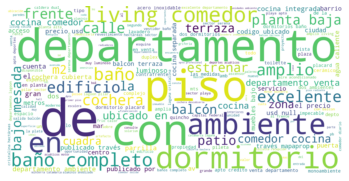

In [868]:
create_wordcloud('apartment')

Se presentan expresiones como *terraza, cochera cubierta, patio* que hablan de una determinada superficie que no está bien contada en la total.

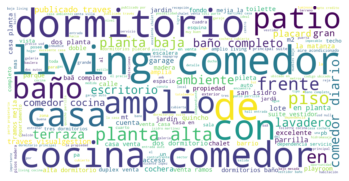

In [869]:
create_wordcloud('house')

Palabras como *jardín, garage, pileta, terraza* indican que no está bien contada la superficie total.

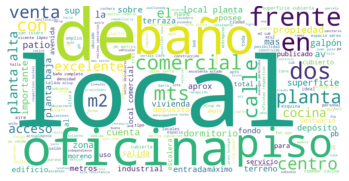

In [870]:
create_wordcloud('store')

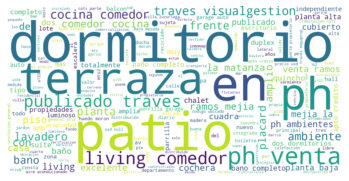

In [871]:
create_wordcloud('PH')

Por ultimo, encontramos *terraza, patio, cubierto, planta, duplex* que emergen de forma muy repetida y nos llevan hacia la misma conclusión.

Tomemos algunos casos particulares para analizarlos

In [872]:
np.random.seed(19)

for property_type in greater_covered_than_total.property_type.unique():
    problematic_rows_by_proptype = greater_covered_than_total[greater_covered_than_total.property_type == property_type]
    random_problematic_rows = np.random.choice(problematic_rows_by_proptype.index, 3)
    
    print(f"Para {property_type}")
    for i in random_problematic_rows:
        titulo = greater_covered_than_total.loc[i].title
        descripcion = greater_covered_than_total.loc[i].description
        covered = greater_covered_than_total.loc[i].surface_covered_in_m2
        total = greater_covered_than_total.loc[i].surface_total_in_m2

        print(f"""
    index = {i}
    El título es: {titulo}
    La descripción: {descripcion}
    Mientras que la publicación indica {covered} m2 cubiertos y {total} m2 totales
""")

Para house

    index = 104709
    El título es: Casa - La Plata
    La descripción: VENTA CASA  - Calle 70 entre 5 y 6Sobre lote de 128.75m2. Muy buena casa de 45 años de antigüedad estilo señorial desarrollada en 2 plantas. En Planta Baja con amplio living, cocina comedor equipada y toilette. En Planta Baja 3 dormitorios con placard, baño completo, lavadero cubierto y cochera cubierta par a un auto.  Pisos de granito y carpintería de chapa y madera.   
    Mientras que la publicación indica 182.0 m2 cubiertos y 129.0 m2 totales


    index = 107173
    El título es: Casa - Barrancas del Lago
    La descripción:                 Gran lote con vista al lago muelle, quincho cerrado con aire acondicionado, pileta, 4 dormitorios, amplia cocina lavadero  y dependencia            
    Mientras que la publicación indica 305.0 m2 cubiertos y 42.0 m2 totales


    index = 36961
    El título es: EN VENTA - GRANADERO BAIGORRIA. COMODA Y MUY LINDA
    La descripción: Emplazada en 2 plantas. Cuent

Lo que vamos a hacer es filtrar estos registros porque son muy pocos, cerca de 1100

In [873]:
def clean_total_surface(df):
    covered_beyond_total = df.surface_covered_in_m2 > df.surface_total_in_m2
    not_covered_beyond_total = ~covered_beyond_total
    not_zero = (df.surface_total_in_m2 != 0) & (df.surface_covered_in_m2 != 0)
    return df.loc[not_covered_beyond_total & not_zero]
    
df = clean_total_surface(df)

In [874]:
df.shape

(119729, 26)

Como futura mejora que se puede plantear es crear un feature en Properati que indique a los usuarios que probablemente se han equivocado en el ingreso de datos, esto ayudaría a que las publicaciones se encuentren con mayor publicidad.

**¿Qué sucede con estos valores? ¿Cuál es su distribución?**

Estudiemos qué está sucediendo con los registros sin superficie total especificada, pero con superficie cubierta. Para comenzar, veamos qué valores toman estas variables.

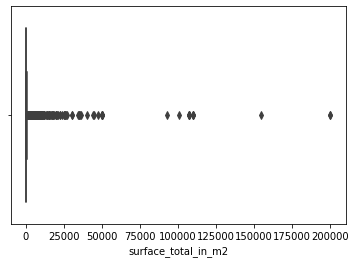

In [875]:
import seaborn as sns

sns.boxplot(df.surface_total_in_m2)

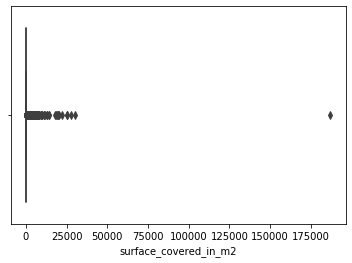

In [876]:
sns.boxplot(df.surface_covered_in_m2)

Vemos que en ambos casos existe gran cantidad de outliers sobretodo a la derecha, grafiquemos de nuevo pero removiendo outliers con la estrategia del rango intercuartil.

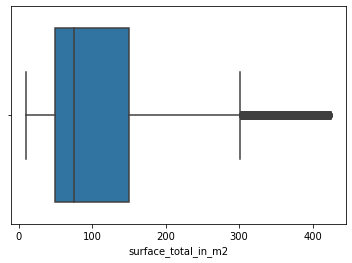

In [877]:
lower_total, upper_total = get_outlier_bounds(df.surface_total_in_m2)
total_m2_no_outliers_mask = (df.surface_total_in_m2 > lower_total) & (df.surface_total_in_m2 < upper_total)
total_m2_no_outliers = df.surface_total_in_m2[total_m2_no_outliers_mask]

sns.boxplot(total_m2_no_outliers)

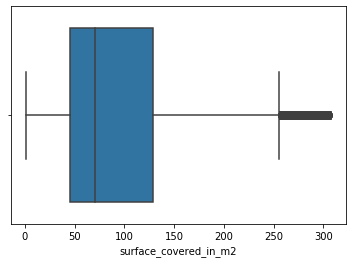

In [878]:
lower_covered, upper_covered = get_outlier_bounds(df.surface_covered_in_m2)
covered_m2_no_outliers_mask = (df.surface_covered_in_m2 > lower_covered) & (df.surface_covered_in_m2 < upper_covered)
covered_m2_no_outliers = df.surface_covered_in_m2[covered_m2_no_outliers_mask]

sns.boxplot(covered_m2_no_outliers)

In [879]:
taken_observations = df.loc[covered_m2_no_outliers_mask & total_m2_no_outliers_mask].shape[0]
total_observations = df.loc[~df.surface_covered_in_m2.isnull() & ~df.surface_total_in_m2.isnull()].shape[0]
percentage = 100 * taken_observations / total_observations
print(f"{percentage:.2f}% valores fueron tomados")

87.98% valores fueron tomados


**¿Existe relación entre estas variables?**

In [880]:
data = df.loc[
    covered_m2_no_outliers_mask & total_m2_no_outliers_mask,
    ['surface_covered_in_m2', 'surface_total_in_m2', 'property_type']
]

data.groupby('property_type').corr()

surface_covered_in_m2  \
property_type                                                
PH            surface_covered_in_m2               1.000000   
              surface_total_in_m2                 0.808574   
apartment     surface_covered_in_m2               1.000000   
              surface_total_in_m2                 0.912214   
house         surface_covered_in_m2               1.000000   
              surface_total_in_m2                 0.572116   
store         surface_covered_in_m2               1.000000   
              surface_total_in_m2                 0.931601   

                                     surface_total_in_m2  
property_type                                             
PH            surface_covered_in_m2             0.808574  
              surface_total_in_m2               1.000000  
apartment     surface_covered_in_m2             0.912214  
              surface_total_in_m2               1.000000  
house         surface_covered_in_m2             0.572116  
              surface_total_in_m2               1.000000  
store         surface_covered_in_m2             0.931601  
              surface_total_in_m2               1.000000

Con el coeficiente de correlación nos damos cuenta que estas variables están altamente relacionadas

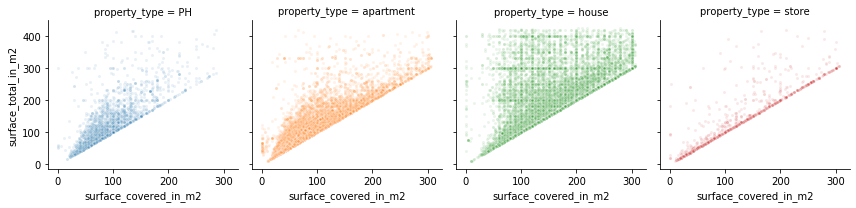

In [881]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.FacetGrid(data, col="property_type", hue = "property_type")
g.map(plt.scatter, "surface_covered_in_m2", "surface_total_in_m2", edgecolor="w", marker = '.', alpha = 0.1)

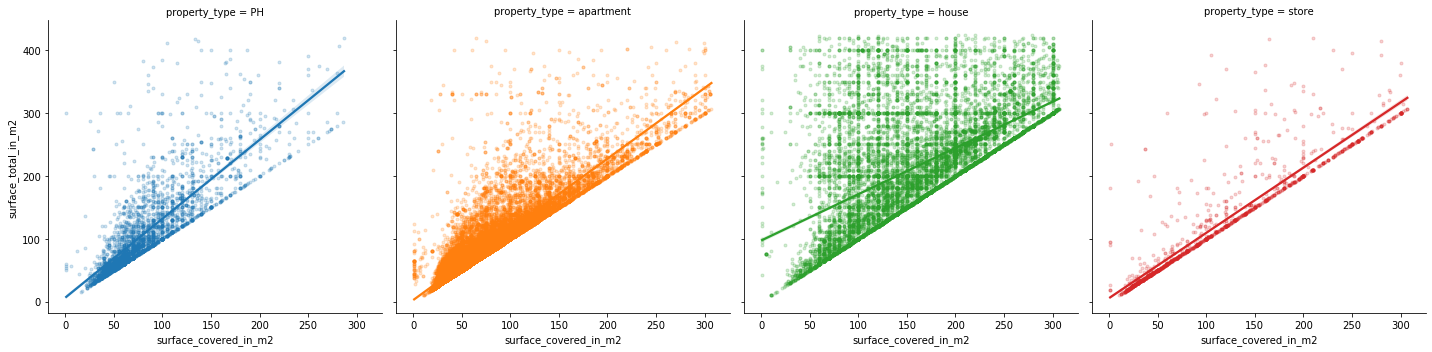

In [882]:
g =sns.lmplot(
    x="surface_covered_in_m2",
    y="surface_total_in_m2",
    col="property_type",
    hue="property_type",
    data = data,
    markers='.',
    scatter_kws={'alpha': 0.2}
)

Vemos una fuerte relación entre los tipos de propiedad PH, apartament y store. Además, en el tipo de propiedad house, vemos una cierta relación sin embargo no es tan fuerte como en los otros casos.

Ahora bien, como lo que queremos es tener un cálculo con un cierto grado de error del total de metros cuadrados teniendo los metros cuadrados cubiertos para poder rellenar los registros nulos, vamos a realizar una regresión lineal simple con el módulo scipy que, convenientemente devuelve el error estándar.

In [883]:
from scipy import stats
from IPython.display import Markdown, display

results = {}

for property_type in data.property_type.unique():
    property_type_mask = data.property_type == property_type
    data_for_property_type = data[property_type_mask]
    
    result = stats.linregress(
        data_for_property_type.surface_covered_in_m2,
        data_for_property_type.surface_total_in_m2
    )
    
    results[property_type] = result
    
    slope, intercept, r_value, p_value, std_err = result
    
    display(Markdown(f"""
Para {property_type} obtuvimos una regresión con error típico de {std_err} y el p-value del test Wald es {p_value}
    """))
    


Para PH obtuvimos una regresión con error típico de 0.015947928876791032 y el p-value del test Wald es 0.0
    


Para apartment obtuvimos una regresión con error típico de 0.002372333279179766 y el p-value del test Wald es 0.0
    


Para house obtuvimos una regresión con error típico de 0.008846659146841294 y el p-value del test Wald es 0.0
    


Para store obtuvimos una regresión con error típico de 0.010188104821009472 y el p-value del test Wald es 0.0
    

Este approach para aproximar la variable faltanta ```surface_total_in_m2``` aunque nos parece naive, el error típoco nos parece asequible para la unidad de metros cuadrados, porque si fijamos $\alpha = 0.05$ y construimos el intervalo de confianza para la predicción nos daría que, en cada caso:

In [884]:
alpha = 0.05

for property_type in results.keys():
    b0, b1, _, _, std_err = result
    
    N = data.property_type.value_counts()[property_type]
    z = stats.t.ppf(alpha / 2, df = N - 1)
    
    property_type_mask = (data.property_type == property_type)
    data_for_property_type = data[property_type_mask]
    
    x = data_for_property_type.surface_covered_in_m2
    y = data_for_property_type.surface_total_in_m2
    y_pred = b0 + b1 * x
    
    # Predicción acotada inferiormente por surface covered
    yhat = np.where(y_pred > x, y_pred, x)
    
    sum_errs = np.sum((y - yhat)**2)
    stdev = np.sqrt(1 / (N-1) * sum_errs)
    
    interval_95 = np.abs(z * stdev)

    display(Markdown(f"""
Para {property_type} el valor de ```surface_total_in_m2``` estaría {interval_95:.2f} $m^2$ por arriba o por abajo de lo calculado
    """))


Para PH el valor de ```surface_total_in_m2``` estaría 796.07 $m^2$ por arriba o por abajo de lo calculado
    


Para apartment el valor de ```surface_total_in_m2``` estaría 658.75 $m^2$ por arriba o por abajo de lo calculado
    


Para house el valor de ```surface_total_in_m2``` estaría 1505.06 $m^2$ por arriba o por abajo de lo calculado
    


Para store el valor de ```surface_total_in_m2``` estaría 1199.38 $m^2$ por arriba o por abajo de lo calculado
    

**Nota**: Hemos acotado inferiormente la predicción de la superficie total por la propia superficie cubierta.

No nos quedamos tranquilos con el intervalo de confianza y probamos otro approach aproximando el valor de la superficie total a la superficie cubierta. Veamos qué intervamos de confianza podemos tener fijando $\alpha = 0.05$

In [885]:
alpha = 0.05

for property_type in results.keys():
    N = data.property_type.value_counts()[property_type]
    z = stats.t.ppf(alpha / 2, df = N - 1)
    
    property_type_mask = (data.property_type == property_type)
    data_for_property_type = data[property_type_mask]
    
    x = data_for_property_type.surface_covered_in_m2
    y = data_for_property_type.surface_total_in_m2
    # Iguala el la superficie total a la superficie cubierta
    yhat = x
    
    sum_errs = np.sum((y - yhat)**2)
    stdev = np.sqrt(1/(N-1) * sum_errs)
    
    interval_95 = np.abs(z * stdev)

    display(Markdown(f"""
Para {property_type} el valor de ```surface_total_in_m2``` estaría {interval_95:.2f} $m^2$ por arriba o por abajo de lo calculado
    """))


Para PH el valor de ```surface_total_in_m2``` estaría 96.45 $m^2$ por arriba o por abajo de lo calculado
    


Para apartment el valor de ```surface_total_in_m2``` estaría 44.78 $m^2$ por arriba o por abajo de lo calculado
    


Para house el valor de ```surface_total_in_m2``` estaría 176.99 $m^2$ por arriba o por abajo de lo calculado
    


Para store el valor de ```surface_total_in_m2``` estaría 65.37 $m^2$ por arriba o por abajo de lo calculado
    

Este intervalo de confianza que se produce al igualar ambas variables nos deja mas tranquilos y sentamos las bases hacer una iteración en el futuro que produzca intervalos de confianza más acotados. Vamos a aplicarla a todos los tipos de propiedad excepto en casas, porque el intervalo no nos convence.

In [886]:
def fill_missing_surface_total(df):
    has_covered = ~df.surface_covered_in_m2.isnull()
    has_no_total = df.surface_total_in_m2.isnull()
    is_not_house = ~(df.property_type == 'house')
    
    mask = has_covered & has_no_total & is_not_house
    print(mask)
    df['surface_total_in_m2'] = np.where(mask, df.surface_covered_in_m2, df.surface_total_in_m2)
    df['surface_total_in_m2_reliable'] = ~mask

In [887]:
fill_missing_surface_total(df)

imputed_surface_total = (~df.surface_total_in_m2_reliable).sum()
non_imputed_surface_total = df.surface_total_in_m2.isnull().sum()

display(Markdown(f"""
Imputamos {imputed_surface_total} valores de ```surface_total_in_m2```,
quedan {non_imputed_surface_total} para los cuales no tenemos ninguna de las dos variables
"""))

0         False
1         False
2         False
3         False
4         False
          ...  
121215    False
121216    False
121217    False
121218    False
121219    False
Length: 119729, dtype: bool



Imputamos 16146 valores de ```surface_total_in_m2```,
quedan 23182 para los cuales no tenemos ninguna de las dos variables


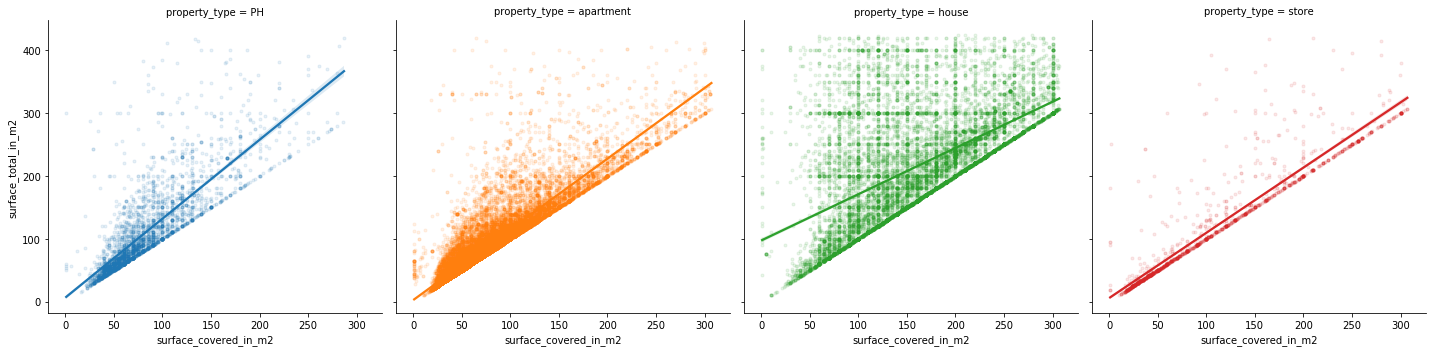

In [888]:
g =sns.lmplot(
    x="surface_covered_in_m2",
    y="surface_total_in_m2",
    col="property_type",
    hue="property_type",
    data = df[covered_m2_no_outliers_mask & total_m2_no_outliers_mask],
    markers='.',
    scatter_kws={'alpha': 0.1}
)

**Insight** mientras más grandes son las propiedades se hace más probable que cuenten con espacios no cubiertos como jardines.

#### Imputación de superficie total utilizando otras variables disponibles

**¿De las superficies nulas, que otras variables tenemos disponibles? ¿Están relacionadas con la superficie?**

In [889]:
available_rooms_data = (df.surface_total_in_m2.isnull() & ~df.rooms.isnull()).sum()

print(f"De los registros sin superficie especificada, tenemos {available_rooms_data} registros con los ambientes especificados")

De los registros sin superficie especificada, tenemos 8692 registros con los ambientes especificados


Nos preguntamos si sería posible utilizar esta variable para estimar la superficie.

In [890]:
display(Markdown("Apartamentos"))
display(df.loc[df.property_type == 'apartment', ['surface_covered_in_m2', 'rooms']].corr())

display(Markdown("Casas"))
display(df.loc[df.property_type == 'house', ['surface_covered_in_m2', 'rooms']].corr())

display(Markdown("Store"))
display(df.loc[df.property_type == 'store', ['surface_covered_in_m2', 'rooms']].corr())

display(Markdown("PH"))
display(df.loc[df.property_type == 'PH', ['surface_covered_in_m2', 'rooms']].corr())

Apartamentos

,surface_covered_in_m2,rooms
surface_covered_in_m2,1.000000,0.206086
rooms,0.206086,1.000000


Casas

,surface_covered_in_m2,rooms
surface_covered_in_m2,1.000000,0.140155
rooms,0.140155,1.000000


Store

,surface_covered_in_m2,rooms
surface_covered_in_m2,1.000000,0.536465
rooms,0.536465,1.000000


PH

,surface_covered_in_m2,rooms
surface_covered_in_m2,1.000000,0.565629
rooms,0.565629,1.000000


Vemos que el caso de mayor correlacion entre ambas variables se da para los PH, sin embargo es muy pequeña la correlación.

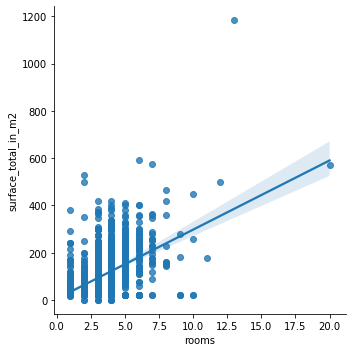

In [891]:
data = df.loc[df.property_type == 'PH', ['surface_total_in_m2', 'surface_covered_in_m2', 'rooms']]
sns.lmplot(data = data, y = 'surface_total_in_m2', x = 'rooms')

Descartamos la idea de intentar estimar la superficie (desconocidas) de las propiedades usando la cantidad de ambientes dado que, aunque existe una relación entre esas variables, no es una lo suficientemente fuerte.

**¿Podríamos utilizar el texto?**

In [892]:
without_surface = df.surface_total_in_m2.isnull()
df.loc[without_surface, ['title', 'description']]

,title,description
1,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,Venta de departamento en décimo piso al frente...
3,PH 3 amb. cfte. reciclado,PH 3 ambientes con patio. Hay 3 deptos en lote...
9,WHITE 7637 - 2 DORMITORIOS CON PATIO,MEDNOZA AL 7600A UNA CUADRA DE CALLE MENDOZAWH...
11,CHALET,"Entrada de Coche, Jardin, Living en desnivel, ..."
65,LOCAL COMERCIAL CON BAÑO,CODIGO: 1092-VENTA 6886 ubicado en: COMBET 688...
...,...,...
121155,Los Lagartos para reciclar,Casa a reciclar en una planta.130 m2 cubiertos...
121156,Los Lagartos para reciclar,Casa a reciclar en una planta.130 m2 cubiertos...
121207,"Casa en venta Puertos, barrio Vistas",Puertos- Barrio Vistas - L. 88Casa en venta so...
121208,"Casa en venta Puertos, barrio Vistas",Puertos- Barrio Vistas - L. 88Casa en venta so...


In [893]:
np.random.seed(19)
indices = df.loc[without_surface].index
sample_indices = np.random.choice(indices, size = 5)

for i in sample_indices:
    display(Markdown(f"""
    i = {i}
    Titulo: {df.iloc[i].title}
    Descripcion: {df.iloc[i].description}
    """))


    i = 63128
    Titulo: 3 ambientes en Yoo!
    Descripcion: VENTA CON RENTA!Espectacular Departamento en el complejo más exclusivo de Nordelta !!!Con vista a la cancha del golf. Con adicionales, todos los baños hechos en  marmol.Cocina - Estar/Comedor- Vestidor-2:  1 Dormitorio en suite /1 dormitorio- Baño y Toilette , Terraza con vista al Golf.Tiene cochera aprox 18 m2. Gabriela Iglesias Negocios InmobiliariosMás de 15 años comercializando propiedades en NordeltaOf. NordeltaT:  y RotD: Bahia Grande Local 7 NordeltaM: Of. Villanueva T:  y RotD: Dean Funes y Boulevard VillanuevaM: Horarios: Lun a Sab 10 a 18hs CONSULTA NUESTRO SITIO WEB: Código Referencia Propiedad: GAP75130
    


    i = 95758
    Titulo: Chalet de cinco ambientes.  Apto crédito. Haedo.
    Descripcion:             Excelente chalet de cinco ambientes. Muy buen acceso, constituido en dos plantas. PB- Cuenta con living con hogar a leña, toda carpintería de madera, pisos de madera tarugados, cocina-comedor totalmente equipada con pisos de madera y baño completo PA. Cuatro dormitorios con pisos de madera tarugados, baño principal con jacuzzi y baño completo. Todos los ambientes cuentan con aire acondicionado y calefacción central por radiadores, entrada pasante para dos autos. Jardín con parrilla y pileta climatizada. APTO CRÉDITO.        Espinosa Negocios InmobiliariosTel: -  – Gral. Arenales 686. Moron. (1708)
    


    i = 9264
    Titulo: Casa 811m² con 2 Plantas, Bs.As. G.B.A. Zona Norte, Pilar, por U$S 365.000
    Descripcion: Muy buena casa en el Club de Campo PueyrredÃ³n - Autopista del Sol Ramal Pilar, km 49PLANTA BAJA: Hall - Estar / comedor - amplia cocina - family - toilette - Dependencias de servicio - lavaderoGalerÃ­a - parrilla - pileta de nataciÃ³nPLANTA ALTA: Hall de distribuciÃ³n - Dormitorio ppal en suite c /vestidor - terraza c/ jacuzzi - otros 3 dormitorios c/baÃ±o completoCalefacciÃ³n x piso radiante (tiene salamandra x si no quieren usar la calefacciÃ³n central)AA x split en todos los ambientes El Barrio cuenta con:Agua corriente - red cloacal - red de gas - telefonÃ­a y TV x cable (todo subterraneo)Tennis: 3 canchas rÃ¡pidasFootball: 2 canchas y 1 de papi- footballcancha de HockeyGimnasio c/ aparatosSPA - sauna - ducha escocesaClases de yoga - Taekwon-doPiscina p/ mayores y p/ niÃ±osTaller de mÃºsica - Colonia de verano - Jardin maternalClub House c/ restaurante - bar y salon p/ mayoresIdem p/ menores con quincho y parrillaExpensas: $ 8.500.-(cuota social y deportes incluidos)INGRESO AL CLUB: Equivalente a 10 expensas
    


    i = 115324
    Titulo: Departamento - Urquiza R
    Descripcion: Detalles de diseño en una torre de triple frente donde se destaca su calidad constructiva, su entorno verde y sus multiples amenities3 ambientes. ( 2 dorm en suite )- y toilette recepción Living comedor con cocina integrada mediante una barra, Uno de los dormitorios con vestidor, otro con placard.Balcón terraza de 1.57m de ancho.Forma de pago : 40 % al boleto y saldo pesificado en 28 cuotas (la primera con vencimiento Junio 17)D'Aria Propiedades ::  :: 
    


    i = 7358
    Titulo: Torre a estrenar / Alto Grande Independencia
    Descripcion: Pozo • Entrega 31/10/2018Ubicado a metros del Corazón de San Telmo (a 300 metros de la Plaza Dorrego) y a solo minutos caminando del microcentro y principales universidades de la zona el edificio Alto Grande Independencia es el espacio ideal para estar cerca de todo. Su moderno diseño cuenta con servicios y amenities de primer nivel para disfrutar de estar en casa. Sus 8 niveles de departamentos con un lay-out de circulación muy eficiente están combinadas con una planta baja de locales comerciales y subsuelos de cocheras. Características:Inmejorable ubicación a metros del corazón de San Telmo Microcentro y principales universidades de la zona además de gran cantidad de medios de transporte a todos los puntos de la capital e interior del país.. Piscina y un muy amplio Solárium con sol todo el día ubicado en una plataforma elevada en lo más alto del edificio con atractivas vistas a la ciudad.• Servicio de conserjería: recepción de correo distribución y entrega de revistas y diarios pedidos de supermercado y otros servicios útiles.• Departamentos eficientes bien diseñados desde Estudios (mono ambientes) a 2 y 3 ambientes con balcones. Ingreso a amplio lobby cómodo y funcional flanqueado por un luminoso deck con un fácil acceso a los ascensores y escaleras.• Gimnasio Vestuarios Laundry.. Estacionamiento en subsuelos con infladores de neumáticos servicio de lavado de autos muy fácil circulación. Bauleras.• Seguridad las 24hs con sistema de monitoreo y control de accesos+ Disposición: al frente.
    

Habiendo tomado una pequeña muestra aleatoria para ver que contienen los textos, se ve que algunas publicaciones se refieren a lotes de propiedades y por lo tanto no incluyen una medida específica. Otro caso que vemos es que se ingresa en la descripcion literalmente las dimensiones de largo x ancho de las superficies mas que de la superficie propiamente dicha.

Busquemos si hay alguna propiedad que indique en el título su superficie directamente.

In [894]:
import re

has_surface_mask = lambda x: bool(re.search(r'([0-9]+(?:\.[0-9]+)?)(?:\,?[0-9]+)? ?(?:mts|m2|m²|m )', x.lower()))
has_surface = (df.title.apply(has_surface_mask) & without_surface).sum()

print(f"Hay {has_surface} registros que especifica metros cuadrados en el título")

Hay 430 registros que especifica metros cuadrados en el título


**Explicación de la regex**: vimos que algunos usuarios incluian decimales o denotaban miles con un punto. Capturamos el número sin decimales que esté seguido de la unidad "metros cuadrados", con el punto incluido. El punto lo reemplazamos después.

In [895]:
df.title[df.title.apply(has_surface_mask)].sample(10).tolist()

['Departamento 59m² con Cochera en Valdenegro 2800, Capital Federal, Villa Urquiza, por U$S 124.000',
 'Excelente local comercial sobre lote propio de 257 m2',
 'San Luis 3300. Casa en venta 5 habitaciones. Muy Amplia. Lote 7m x 30m.',
 'APTO CREDITO - VARESE - COCHERA  - TERRAZA PROPIA 192 M2.',
 'Casa 480m² con Dependencias en Casares, Carlos 700, San Fernando, Victoria, por U$S 520.000',
 'Departamento 40m² con Plantas en Santa Fe, Av. 2100, San Isidro, Martínez, por U$S 120.000',
 'Fondo de Comercio en Venta. 100 m2',
 'Departamento en Venta. Ambientes. Dormitorio. 1 m2. 1 m2c',
 '2 Ambientes de 58m2 a la Venta en Caballito, a Estrenar!! Excelentes Terminaciones',
 'LOCAL 36 M2 (PB) EMPRENDIMIENTO - SAN MARTIN']

Como encontramos una buena cantidad de registros que especifican los metros cuadrados, vamos a seguir este approach y rellenar las superficies utilizando la información que encontramos en el título.

In [896]:
def can_fill_surface(title): return bool(re.search(r'([0-9]+(?:\.[0-9]+)?)(?:\,?[0-9]+)? ?(?:mts|m2|m²|m )', title.lower()))
def get_surface_from_title(title):
    if not can_fill_surface(title): return None
    search = re.search(r'([0-9]+(?:\.[0-9]+)?)(?:\,?[0-9]+)? ?(?:mts|m2|m²|m )', title.lower()).groups(0)[0].replace('.', '')
    return np.float(search)


In [897]:
df.loc[df.title.apply(can_fill_surface)].title.head(10).tolist()

['HAUS VILLAGE / BELLA VISTA / 115m² MAS PATIO / BUENOS AIRES VILLAGE',
 'Casa tipo americana de 3 ambientes sobre lote de 207mts',
 'Inversor a 50 mts de la Plaza de Pilar!! UCA- ',
 'Chalet en Venta. Ambientes. Dormitorios. 220 m2',
 'MODERNA RESIDENCIA EN STELLA MARIS- s/lote 10x43-400m2 CUB.',
 'Departamento en Venta. Ambientes. Dormitorios. 85 m2c',
 'Departamento en Venta. Ambiente. 42 m2c',
 'Casa 605m² con 2 Plantas, Tigre, Nordelta, por U$S 550.000',
 'Casa 1280m² con 3 Plantas en Paso, Juan Jose 600, San Isidro, Martínez, por U$S 1.700.000',
 'Casa 1300m² con 3 Plantas en Paz, José C. 700, San Isidro, Acassuso, por U$S 3.000.000']

In [898]:
df.loc[df.title.apply(can_fill_surface)].title.apply(get_surface_from_title).head(10).tolist()

[115.0, 207.0, 50.0, 220.0, 400.0, 85.0, 42.0, 605.0, 1280.0, 1300.0]

In [899]:
(df.loc[df.title.apply(can_fill_surface)].title.apply(get_surface_from_title) == 0).sum()

0

In [900]:
def fill_missing_surface_with_title(df):
    total = df.surface_total_in_m2
    covered = df.surface_covered_in_m2
    titles = df.title
    
    can_fill = titles.apply(can_fill_surface)
    should_fill_covered = can_fill & covered.isnull()
    should_fill_total = can_fill & total.isnull()
    
    surfaces_from_titles = titles.apply(get_surface_from_title)
    
    filled_total = np.where(should_fill_total, surfaces_from_titles, total)
    filled_covered = np.where(should_fill_covered, surfaces_from_titles, covered)
    
    df['surface_total_in_m2_reliable'] = df.surface_total_in_m2_reliable | ~should_fill_total
    df['surface_total_in_m2'] = filled_total
    
    df['surface_covered_in_m2_reliable'] = ~should_fill_covered
    df['surface_covered_in_m2'] = filled_covered
    
    print(f"Se llenaron {should_fill_covered.sum()} superficies cubiertas y {should_fill_total.sum()} totales")
    
    return filled_total, filled_covered

In [901]:
fill_missing_surface_with_title(df)

Se llenaron 489 superficies cubiertas y 430 totales


(array([55., nan, 55., ..., 46., 48., 77.]),
 array([40., nan, 55., ..., 39., 48., 77.]))

#### Imputación de superficie cubierta utilizando otras variables disponibles

Veamos un poco qué sucede con los registros que no tienen la superficie cubierta especificada.

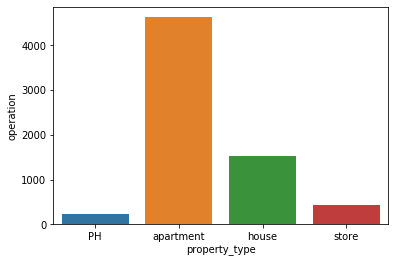

In [902]:
total_without_covered = ~df.surface_total_in_m2.isnull() & df.surface_covered_in_m2.isnull()
nullls_by_ptype = df.loc[total_without_covered].groupby('property_type').count().operation
sns.barplot(x = nullls_by_ptype.index, y = nullls_by_ptype)

In [903]:
df.loc[total_without_covered & (df.property_type == 'apartment')].title.sample(20).tolist()

['Departamento - Villa Luro',
 'DEPARTAMENTO EN VENTA',
 'Venta 2 ambientes',
 'DEPARTAMENTO EN VENTA',
 'Departamento - Rosario',
 'Departamento - Centro',
 'Z/ Pza Mitre 2 Amb. A ESTRENAR',
 'Departamento - Rosario',
 'Departamento - Nueva Cordoba',
 'Departamento en Villa Luro',
 'Departamento - Echesortu',
 'Departamento en Liniers',
 '2 ambientes a estrenar ',
 'Departamento - Rosario',
 'Departamento - Palermo Soho',
 'Departamento en P.Chacabuco',
 'UBICACION PERFECTA!!',
 'DEPARTAMENTO 2 AMBIENTES EN VENTA MAR DEL PLATA',
 'DEPARTAMENTO EN VENTA',
 'EXCELENTE DPTO. A ESTRENAR CÉNTRICO 3 DORMITORIOS $ 3.100.000!!']

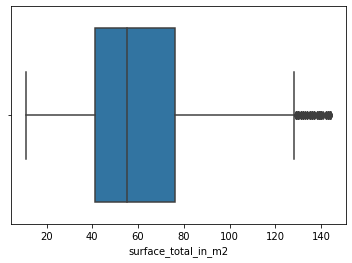

In [904]:
total_without_covered_data = df.loc[total_without_covered & (df.property_type == 'apartment')].surface_total_in_m2
lower, upper = get_outlier_bounds(total_without_covered_data)
no_outliers = (total_without_covered_data > lower) & (total_without_covered_data < upper)
sns.boxplot(total_without_covered_data[no_outliers])

In [905]:
total_without_covered_data[no_outliers].describe()

count    4353.000000
mean       61.719274
std        26.754204
min        11.000000
25%        41.000000
50%        55.000000
75%        76.000000
max       144.000000
Name: surface_total_in_m2, dtype: float64

In [906]:
print(f"El 99% de las observaciones es <= {total_without_covered_data.quantile(.99)}")

El 99% de las observaciones es <= 300.0


Vamos a seguir el mismo approach que hicimos anteriormente pero al contrario, vamos a igualar el valor de la superficie cubierta a la superficie total de la propiedad. Veamos que intervalo de confianza tenemos al realizarlo:

In [907]:
lower, upper = get_outlier_bounds(df.surface_total_in_m2)

no_outliers_mask = (df.surface_total_in_m2 > lower) & (df.surface_total_in_m2 < upper)
has_total_mask = ~df.surface_total_in_m2.isnull()
hasnt_covered_mask = ~df.surface_covered_in_m2.isnull()
no_previously_regress = ~df.surface_total_in_m2_reliable

imputation_target_mask = no_outliers_mask & has_total_mask & hasnt_covered_mask & no_previously_regress

data = df.loc[imputation_target_mask]
ptypes = data.property_type.unique().tolist()

In [908]:
alpha = 0.05

for property_type in ptypes:
    N = data.property_type.value_counts()[property_type]
    z = stats.t.ppf(alpha / 2, df = N - 1)
    
    property_type_mask = (data.property_type == property_type)
    data_for_property_type = data[property_type_mask]
    
    y = data_for_property_type.surface_covered_in_m2
    x = data_for_property_type.surface_total_in_m2
    yhat = x
    
    sum_errs = np.sum((y - yhat)**2)
    stdev = np.sqrt(1/(N-1) * sum_errs)
    
    interval_95 = np.abs(z * stdev)

    display(Markdown(f"""
Para {property_type} el valor de ```surface_total_in_m2``` estaría {interval_95:.2f} $m^2$ por arriba o por abajo de lo calculado
    """))

Los intervalos de confianza (ignorando los registros que previamente modificamos) son inclusive ligeramente mejores que los que construimos anteriormente, por lo cual seguimos este approach.

In [909]:
def fill_missing_surface_covered(df):
    is_not_house = ~(df.property_type == 'house')
    total_without_covered = ~df.surface_total_in_m2.isnull() & df.surface_covered_in_m2.isnull()
    mask = is_not_house & total_without_covered
    
    surface_covered_in_m2 = np.where(mask, df.surface_total_in_m2, df.surface_covered_in_m2)
    df['surface_covered_in_m2_reliable'] = df.surface_covered_in_m2_reliable | ~mask
    df['surface_covered_in_m2'] = surface_covered_in_m2

In [910]:
fill_missing_surface_covered(df)

In [911]:
nulls_by_column = 100 * df.isnull().sum() / df.count()

print(f"""
Hay {nulls_by_column['surface_covered_in_m2']:.2f}% de nulos en la parte de superficies
""")


Hay 12.97% de nulos en la parte de superficies



##### 5. Imputación de la columna ```price_usd_per_m2``` utilizando la columna ```price``` y ```surface_total_in_m2```

Como ya hemos imputado las columnas referentes a la superficie y estimamos la tasa de cambio, procedemos a calcular el precio por metro cuadrado faltantes

**¿Cuantos registros tienen especificada la superficie y el precio pero no el precio por metro cuadrado en USD?**

In [912]:
has_price = ~df.price.isnull()
hasnt_price_m2 = df.price_usd_per_m2.isnull()
has_surface = ~df.surface_total_in_m2.isnull()

target_imputation_mask = has_price & hasnt_price_m2 & has_surface
target_imputation_mask.sum()

print(f"""
Hay {target_imputation_mask.sum()} los cuales podemos imputar de un total de {hasnt_price_m2.sum()}
que no tienen precio. Esto es un {(100 * target_imputation_mask.sum() / hasnt_price_m2.sum()):.2f}%
""")


Hay 15269 los cuales podemos imputar de un total de 52091
que no tienen precio. Esto es un 29.31%



In [913]:
df.currency.value_counts()

USD    86509
ARS    13069
PEN        2
UYU        1
Name: currency, dtype: int64

In [914]:
df[target_imputation_mask].currency.value_counts()

USD    13159
ARS     2110
Name: currency, dtype: int64

De los valores de precio por metro cuadrado que podemos imputar en este approach, solo hay en pesos y en dólares.

**¿Para calcular el precio por metro cuadrado, uso el total o el cubierto?**

In [915]:
is_usd = df.currency == 'USD'
aspect_to_total = (df[is_usd].price / df[is_usd].surface_total_in_m2) / df[is_usd].price_usd_per_m2
aspect_to_covered = (df[is_usd].price / df[is_usd].surface_covered_in_m2) /  df[is_usd].price_usd_per_m2

In [916]:
aspect_to_total.quantile(.91)

1.0000000000000002

In [917]:
(df[is_usd].surface_total_in_m2 == 0).sum()

0

In [918]:
aspect_to_total.shape

(86509,)

In [919]:
aspect_to_total.describe()

count    5.924200e+04
mean     1.000000e+00
std      1.171386e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [920]:
aspect_to_covered.describe()

count    58150.000000
mean         1.750227
std         12.921693
min          0.099762
25%          1.000000
50%          1.093023
75%          1.263158
max       2500.000000
dtype: float64

In [921]:
(df[is_usd][aspect_to_total != 1].surface_total_in_m2_reliable).sum()

46433

In [922]:
(~df[is_usd][aspect_to_total != 1].surface_total_in_m2_reliable).sum()

0

In [923]:
(~df.surface_total_in_m2_reliable).sum()

0

In [924]:
(df[is_usd][aspect_to_total < 1].groupby('currency').surface_total_in_m2_reliable).count()

currency
USD    10276
Name: surface_total_in_m2_reliable, dtype: int64

Vemos que el que tiene menor desvío es la relación precio - superficie total. En la cuenta de la máscara anterior nos dimos cuenta que se debe a que muchos de los precios por metro cuadrado estan calculados con error, la mayoría de ellos vinieron así en el dataset (superficie reliable, no imputada). En consecuencia vemos la necesidad de recalcular el precio por metro cuadrado.

**Calculamos el precio por metro cuadrado en dólares para los precios en pesos**

In [925]:
def compute_price_usd_per_m2_for_ars(df):
    # Masks
    is_ars = df.currency == 'ARS'
    has_price = ~df.price.isnull()
    hasnt_price_m2 = df.price_usd_per_m2.isnull()
    has_surface = ~df.surface_total_in_m2.isnull()

    # Compose masks
    target_imputation_mask = has_price & hasnt_price_m2 & has_surface & is_ars
    
    # Get and apply currency conversion
    usd_ars = get_ars_2_usd_trimmed_mean(df)
    converted_price_per_m2 = (df.price / usd_ars) / df.surface_total_in_m2

    # Replace converted values only when the masks applies
    price_usd_per_m2 = np.where(target_imputation_mask, converted_price_per_m2, df.price_usd_per_m2)
    df["price_usd_per_m2"] = price_usd_per_m2
    
    print(f"Se calcularon {target_imputation_mask.sum()} precios por m2")

In [926]:
compute_price_usd_per_m2_for_ars(df)

Se calcularon 2110 precios por m2


**Calculamos el precio por metro cuadrado en dólares para los precios en dólares**

In [927]:
def compute_price_usd_per_m2_for_usd(df):
    # Masks
    is_usd = df.currency == 'USD'
    has_price = ~df.price.isnull()
    has_surface = ~df.surface_total_in_m2.isnull()

    # Compose masks
    target_imputation_mask = has_price & has_surface & is_usd
    
    # Get and apply currency conversion
    converted_price_per_m2 = df.price / df.surface_total_in_m2
    
    # Replace converted values only when the masks applies
    price_usd_per_m2 = np.where(target_imputation_mask, converted_price_per_m2, df.price_usd_per_m2)
    df["price_usd_per_m2"] = price_usd_per_m2
    
    print(f"Se calcularon {target_imputation_mask.sum()} precios por m2")

In [928]:
compute_price_usd_per_m2_for_usd(df)

Se calcularon 72401 precios por m2


In [929]:
100 * df.isnull().sum() / df.isnull().count()

Unnamed: 0                         0.000000
operation                          0.000000
property_type                      0.000000
place_name                         0.019210
place_with_parent_names            0.000000
country_name                       0.000000
state_name                         0.000000
geonames_id                       15.390590
lat-lon                           42.524368
lat                               42.524368
lon                               42.524368
price                             16.827168
currency                          16.828003
price_aprox_local_currency        16.827168
price_aprox_usd                   16.827168
surface_total_in_m2               19.002915
surface_covered_in_m2             11.480928
price_usd_per_m2                  30.754454
price_per_m2                      27.602335
floor                             93.415964
rooms                             60.795630
expenses                          88.161598
properati_url                   

In [930]:
(df[is_usd].price_usd_per_m2 == 0).sum()

0

In [931]:
((df[is_usd].price / df[is_usd].surface_total_in_m2) / df[is_usd].price_usd_per_m2).describe()

count    72401.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [932]:
(((df[is_usd].price / df[is_usd].surface_total_in_m2) / df[is_usd].price_usd_per_m2) != 1).sum()

14108